# Relación entre arrestos de personas de distintas razas y la cantidad de arrestos por estado en EEUU, entre 2018 y 2020.

0. trabajo datos

In [1]:
import pandas as pd
import geopandas as gpd
import json
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# https://www.fbi.gov/services/cjis/ucr/publications : Dataframe (18, 19) * las del 2020 esta solo el dataframe por raza
# 29 Numero de arrestos por ofensa
# 43- 49 - 55 - 61 - 67 numero de arrestos por raza
# 69 numero de arrestos por estado sobre/bajo 18 años

import requests
import os
lista_anos = [2019,2018,2017]
lista_numeros_tablas = [29, '55a' ,69]

try:
    for ano in lista_anos:
        os.makedirs(f'Data_fbi_ucr/{ano}_datos')
        for num_tabla in lista_numeros_tablas:
            dls = f"https://ucr.fbi.gov/crime-in-the-u.s/{ano}/crime-in-the-u.s.-{ano}/tables/table-{num_tabla if num_tabla != '55a' else 55}/table-{num_tabla}.xls/output.xls"
            resp = requests.get(dls)
            
            with open(f'Data_fbi_ucr/{ano}_datos/tabla_{num_tabla}.xls', 'wb') as output:
                output.write(resp.content)
except FileExistsError:
    print('ya existen estos archivos')


ya existen estos archivos


In [ ]:
tabla_55a_2019 =  pd.read_excel('Data_fbi_ucr/2019_datos/tabla_55a.xls')
tabla_55a_2019 = tabla_55a_2019.rename(columns=tabla_55a_2019.iloc[6]).iloc[7:].reset_index().drop(columns=['index'])
tabla_55a_2019.head()

In [ ]:
tabla_55a_2018 =  pd.read_excel('Data_fbi_ucr/2018_datos/tabla_55a.xls')
tabla_55a_2018 = tabla_55a_2018.rename(columns=tabla_55a_2018.iloc[6]).iloc[7:].reset_index().drop(columns=['index'])
tabla_55a_2018.head()

In [ ]:
# usar api fbi
# codigo de todas los estados : https://api.usa.gov/crime/fbi/sapi/api/states?API_KEY=iiHnOKfno2Mgkt5AynpvPpUQTEyxE77jo1RU8PIv&size=100
# arrestos en la region por raza: https://api.usa.gov/crime/fbi/sapi/api/arrest/states/CA/all/race/2020/2020?API_KEY=iiHnOKfno2Mgkt5AynpvPpUQTEyxE77jo1RU8PIv

In [3]:
# extraemos los codigos de todos los estados
key = '1jL8OaKHoKG21Thdsnx6ep5Zi9qaLidKUT4jIIyu'
url_codes = f'https://api.usa.gov/crime/fbi/sapi/api/states?API_KEY={key}&size=100'

r=requests.get(url_codes)
r.json()


{'results': [{'state_id': 1,
   'state_name': 'Alaska',
   'state_abbr': 'AK',
   'region_code': 4,
   'state_fips_code': 2},
  {'state_id': 2,
   'state_name': 'Alabama',
   'state_abbr': 'AL',
   'region_code': 3,
   'state_fips_code': 1},
  {'state_id': 3,
   'state_name': 'Arkansas',
   'state_abbr': 'AR',
   'region_code': 3,
   'state_fips_code': 5},
  {'state_id': 4,
   'state_name': 'American Samoa',
   'state_abbr': 'AS',
   'region_code': 99,
   'state_fips_code': 60},
  {'state_id': 5,
   'state_name': 'Arizona',
   'state_abbr': 'AZ',
   'region_code': 4,
   'state_fips_code': 4},
  {'state_id': 6,
   'state_name': 'California',
   'state_abbr': 'CA',
   'region_code': 4,
   'state_fips_code': 6},
  {'state_id': 7,
   'state_name': 'Colorado',
   'state_abbr': 'CO',
   'region_code': 4,
   'state_fips_code': 8},
  {'state_id': 8,
   'state_name': 'Connecticut',
   'state_abbr': 'CT',
   'region_code': 1,
   'state_fips_code': 9},
  {'state_id': 9,
   'state_name': 'Canal Zo

In [4]:
df_codes=pd.json_normalize(r.json(),record_path='results')
df_codes

,state_id,state_name,state_abbr,region_code,state_fips_code
0,1,Alaska,AK,4,2.0
1,2,Alabama,AL,3,1.0
2,3,Arkansas,AR,3,5.0
3,4,American Samoa,AS,99,60.0
4,5,Arizona,AZ,4,4.0
5,6,California,CA,4,6.0
6,7,Colorado,CO,4,8.0
7,8,Connecticut,CT,1,9.0
8,9,Canal Zone,CZ,99,NaN
9,10,District of Columbia,DC,3,11.0


In [5]:
# Solo vamos a considerar los 50 estados principales
df_codes = df_codes.drop([3,8,9, 41,54, 55, 56, 57])


In [6]:
codigos_estados = df_codes[['state_abbr']].values

In [7]:
# iterar en cada estado para estraer su dataframe de arrestos por raza del 2018 al 2020
lista_anos = [2020,2019,2018,2017]

try:
    for estado in codigos_estados:
        estado = estado[0]
        os.makedirs(f'Data_fbi_arrestos_2017_2020/{estado}_datos_arrestos_raza')
        dls = f"https://api.usa.gov/crime/fbi/sapi/api/arrest/states/{estado}/all/race/2017/2020?API_KEY={key}"
        resp = requests.get(dls)
        with open(f'Data_fbi_arrestos_2017_2020/{estado}_datos_arrestos_raza/datos_{estado}.json', 'wb') as output:
            output.write(resp.content)
except FileExistsError:
    print('ya existen estos archivos')

ya existen estos archivos


In [8]:
df_estados_razas = dict()

for estado in codigos_estados:
    estado = estado[0]
    with open(f'Data_fbi_arrestos_2017_2020\{estado}_datos_arrestos_raza\datos_{estado}.json', 'r') as file:
        params = json.load(file)
        df_estados_razas[estado] = pd.DataFrame.from_dict(params['data'])

In [9]:
df_estados_razas['CA']

,value,data_year,month_num,key
0,26504,2017,0,Asian
1,26954,2018,0,Asian
2,26003,2019,0,Asian
3,21181,2020,0,Asian
4,4246,2017,0,Native Hawaiian
5,4429,2018,0,Native Hawaiian
6,4348,2019,0,Native Hawaiian
7,3434,2020,0,Native Hawaiian
8,180253,2017,0,Black or African American
9,176483,2018,0,Black or African American


1. cantidad de arrstos por estado

In [10]:
# cual es el estado con mayor numero de arrestos por raza y por año
df_2020_arrestos_white = pd.DataFrame()
df_2019_arrestos_white = pd.DataFrame()
df_2018_arrestos_white = pd.DataFrame()

df_2020_arrestos_black = pd.DataFrame()
df_2019_arrestos_black = pd.DataFrame()
df_2018_arrestos_black = pd.DataFrame()


for estado in codigos_estados:
    estado = estado[0]
    df_estado = df_estados_razas[estado]
    df_estado['estado'] = estado
    df_2020_arrestos_white = df_2020_arrestos_white.append(df_estado.loc[19], ignore_index= True)
    df_2019_arrestos_white = df_2019_arrestos_white.append(df_estado.loc[18], ignore_index= True)
    df_2018_arrestos_white = df_2018_arrestos_white.append(df_estado.loc[17], ignore_index= True)

    df_2020_arrestos_black = df_2020_arrestos_black.append(df_estado.loc[11], ignore_index= True)
    df_2019_arrestos_black = df_2019_arrestos_black.append(df_estado.loc[10], ignore_index= True)
    df_2018_arrestos_black = df_2018_arrestos_black.append(df_estado.loc[9], ignore_index= True)


In [11]:
# Ordenamos los dataframes para tener un df final con todo lo que necesitemos por año
df_2020_arrestos = pd.DataFrame()

df_2020_arrestos = df_2020_arrestos.append(df_2020_arrestos_white, ignore_index= True )
df_2020_arrestos = df_2020_arrestos.append(df_2020_arrestos_black, ignore_index= True )
df_2020_arrestos = df_2020_arrestos.groupby(['estado'])
value_ = df_2020_arrestos['value'].apply(list)
key_ = df_2020_arrestos['key'].apply(list)
year_ = df_2020_arrestos['data_year'].apply(list)
df_2020_arrestos = pd.merge(value_, key_, on= 'estado')
df_2020_arrestos = pd.merge(df_2020_arrestos, year_, on= 'estado')
df_2020_arrestos['arrestos_w_2020'] = df_2020_arrestos.apply(lambda row: row.value[0], axis=1)
df_2020_arrestos['arrestos_b_2020'] = df_2020_arrestos.apply(lambda row: row.value[1], axis=1)
df_2020_arrestos['arrestos_total_2020'] = df_2020_arrestos.apply(lambda row: row.arrestos_b_2020 + row.arrestos_w_2020, axis=1)



df_2019_arrestos = pd.DataFrame()

df_2019_arrestos = df_2019_arrestos.append(df_2019_arrestos_white, ignore_index= True )
df_2019_arrestos = df_2019_arrestos.append(df_2019_arrestos_black, ignore_index= True )
df_2019_arrestos = df_2019_arrestos.groupby(['estado'])
value_ = df_2019_arrestos['value'].apply(list)
key_ = df_2019_arrestos['key'].apply(list)
year_ = df_2019_arrestos['data_year'].apply(list)
df_2019_arrestos = pd.merge(value_, key_, on= 'estado')
df_2019_arrestos = pd.merge(df_2019_arrestos, year_, on= 'estado')
df_2019_arrestos['arrestos_w_2019'] = df_2019_arrestos.apply(lambda row: row.value[0], axis=1)
df_2019_arrestos['arrestos_b_2019'] = df_2019_arrestos.apply(lambda row: row.value[1], axis=1)
df_2019_arrestos['arrestos_total_2019'] = df_2019_arrestos.apply(lambda row: row.arrestos_b_2019 + row.arrestos_w_2019, axis=1)


df_2018_arrestos = pd.DataFrame()

df_2018_arrestos = df_2018_arrestos.append(df_2018_arrestos_white, ignore_index= True )
df_2018_arrestos = df_2018_arrestos.append(df_2018_arrestos_black, ignore_index= True )
df_2018_arrestos = df_2018_arrestos.groupby(['estado'])
value_ = df_2018_arrestos['value'].apply(list)
key_ = df_2018_arrestos['key'].apply(list)
year_ = df_2018_arrestos['data_year'].apply(list)
df_2018_arrestos = pd.merge(value_, key_, on= 'estado')
df_2018_arrestos = pd.merge(df_2018_arrestos, year_, on= 'estado')
df_2018_arrestos['arrestos_w_2018'] = df_2018_arrestos.apply(lambda row: row.value[0], axis=1)
df_2018_arrestos['arrestos_b_2018'] = df_2018_arrestos.apply(lambda row: row.value[1], axis=1)
df_2018_arrestos['arrestos_total_2018'] = df_2018_arrestos.apply(lambda row: row.arrestos_b_2018 + row.arrestos_w_2018, axis=1)


df_2020_arrestos = df_2020_arrestos.drop(columns=['value','key','data_year'])
df_2019_arrestos = df_2019_arrestos.drop(columns=['value','key','data_year'])
df_2018_arrestos = df_2018_arrestos.drop(columns=['value','key','data_year'])

display(df_2020_arrestos)
display(df_2019_arrestos)
display(df_2018_arrestos)


,arrestos_w_2020,arrestos_b_2020,arrestos_total_2020
estado,,,
AK,12588.0,1979.0,14567.0
AL,2558.0,1552.0,4110.0
AR,64222.0,30766.0,94988.0
AZ,140616.0,27418.0,168034.0
CA,684148.0,134559.0,818707.0
CO,131484.0,19648.0,151132.0
CT,43678.0,22975.0,66653.0
DE,12442.0,11988.0,24430.0
FL,291.0,162.0,453.0


,arrestos_w_2019,arrestos_b_2019,arrestos_total_2019
estado,,,
AK,13256.0,2227.0,15483.0
AL,81471.0,59461.0,140932.0
AR,87872.0,41228.0,129100.0
AZ,171841.0,31555.0,203396.0
CA,840139.0,168555.0,1008694.0
CO,183480.0,26595.0,210075.0
CT,60407.0,30472.0,90879.0
DE,15382.0,14774.0,30156.0
FL,561.0,254.0,815.0


,arrestos_w_2018,arrestos_b_2018,arrestos_total_2018
estado,,,
AK,14981.0,2232.0,17213.0
AL,90214.0,59074.0,149288.0
AR,90029.0,42628.0,132657.0
AZ,188804.0,31954.0,220758.0
CA,879540.0,176483.0,1056023.0
CO,196486.0,27215.0,223701.0
CT,65839.0,30718.0,96557.0
DE,15048.0,13702.0,28750.0
FL,0.0,0.0,0.0


In [12]:
# como el estado de Florida (FL) en el año 2018 no tiene datos, lo vamos a dejar fuera de los estados que habiamos considerado
df_2020_arrestos = df_2020_arrestos.drop(['FL'])
df_2019_arrestos = df_2019_arrestos.drop(['FL'])
df_2018_arrestos = df_2018_arrestos.drop(['FL'])

In [13]:
df_arrestos_estados = pd.merge(df_2020_arrestos, df_2019_arrestos, on= 'estado')
df_arrestos_estados = pd.merge(df_arrestos_estados, df_2018_arrestos, on='estado')
df_arrestos_totales_estados = df_arrestos_estados[['arrestos_total_2020', 'arrestos_total_2019','arrestos_total_2018']]
df_arrestos_totales_estados
df_arrestos_estados

,arrestos_w_2020,arrestos_b_2020,arrestos_total_2020,arrestos_w_2019,arrestos_b_2019,arrestos_total_2019,arrestos_w_2018,arrestos_b_2018,arrestos_total_2018
estado,,,,,,,,,
AK,12588.0,1979.0,14567.0,13256.0,2227.0,15483.0,14981.0,2232.0,17213.0
AL,2558.0,1552.0,4110.0,81471.0,59461.0,140932.0,90214.0,59074.0,149288.0
AR,64222.0,30766.0,94988.0,87872.0,41228.0,129100.0,90029.0,42628.0,132657.0
AZ,140616.0,27418.0,168034.0,171841.0,31555.0,203396.0,188804.0,31954.0,220758.0
CA,684148.0,134559.0,818707.0,840139.0,168555.0,1008694.0,879540.0,176483.0,1056023.0
CO,131484.0,19648.0,151132.0,183480.0,26595.0,210075.0,196486.0,27215.0,223701.0
CT,43678.0,22975.0,66653.0,60407.0,30472.0,90879.0,65839.0,30718.0,96557.0
DE,12442.0,11988.0,24430.0,15382.0,14774.0,30156.0,15048.0,13702.0,28750.0
GA,57913.0,56461.0,114374.0,63365.0,65614.0,128979.0,126178.0,130449.0,256627.0


Ahora extraemos los datos de poblacion los cuales fueron extraidos de forma de descarga ya que solo estaban disponibles de esta forma en:

In [14]:
pobl_2018 = pd.read_csv('data_poblacion\poblacion_2018.csv', sep=',')
pobl_2019 = pd.read_csv('data_poblacion\poblacion_2019.csv', sep=',')
pobl_2020 = pd.read_csv('data_poblacion\poblacion_2020.csv', sep=',')
pobl_2018.head()

,Location,White,Black,Hispanic,Asian,American Indian/Alaska Native,Native Hawaiian/Other Pacific Islander,Multiple Races,Total,Footnotes
0,United States,192117000.0,38655700.0,58483600.0,17844800.0,2082800.0,519500.0,8795000.0,318498500.0,1.0
1,Alabama,3115600.0,1257300.0,204800.0,63800.0,19000.0,NaN,90700.0,4752600.0,NaN
2,Alaska,426100.0,20700.0,50200.0,43200.0,110300.0,7400.0,51100.0,709100.0,NaN
3,Arizona,3815100.0,297000.0,2213600.0,227200.0,271900.0,12000.0,167400.0,7004300.0,NaN
4,Arkansas,2110400.0,436900.0,224900.0,44200.0,17000.0,8200.0,79700.0,2921300.0,NaN


In [15]:
# ahora solo necesitamos la info de la poblacion White, Black, Total
pobl_2018 = pobl_2018[['Location','White', 'Black','Total']]
pobl_2019 = pobl_2019[['Location','White', 'Black','Total']]
pobl_2020 = pobl_2020[['Location','White', 'Black','Total']]
pobl_2020.head()

,Location,White,Black,Total
0,United States,194000000.0,40439900.0,325637800.0
1,Alabama,3201500.0,1308800.0,4885700.0
2,Alaska,399000.0,22600.0,706100.0
3,Arizona,3977400.0,373300.0,7467800.0
4,Arkansas,2126500.0,440200.0,2977500.0


In [16]:
df_poblacion = pd.merge(pobl_2020, pobl_2019, on='Location')
df_poblacion.rename(columns={
    'White_x': 'poblacion_w_2020',
    'Black_x': 'poblacion_b_2020',
    'Total_x': 'total_2020',
    'White_y':'poblacion_w_2019',
    'Black_y':'poblacion_b_2019',
    'Total_y': 'total_2019'}, inplace=True)
df_poblacion = pd.merge(df_poblacion, pobl_2018, on='Location')
df_poblacion.rename(columns={
    'White': 'poblacion_w_2018',
    'Black': 'poblacion_b_2018',
    'Total': 'total_2018',}, inplace=True)
df_poblacion

,Location,poblacion_w_2020,poblacion_b_2020,total_2020,poblacion_w_2019,poblacion_b_2019,total_2019,poblacion_w_2018,poblacion_b_2018,total_2018
0,United States,194000000.0,40439900.0,325637800.0,191757100.0,38872200.0,319249300.0,192117000.0,38655700.0,318498500.0
1,Alabama,3201500.0,1308800.0,4885700.0,3117200.0,1263500.0,4767100.0,3115600.0,1257300.0,4752600.0
2,Alaska,399000.0,22600.0,706100.0,421100.0,15200.0,701700.0,426100.0,20700.0,709100.0
3,Arizona,3977400.0,373300.0,7467800.0,3843700.0,306600.0,7098000.0,3815100.0,297000.0,7004300.0
4,Arkansas,2126500.0,440200.0,2977500.0,2108400.0,444200.0,2922500.0,2110400.0,436900.0,2921300.0
...,...,...,...,...,...,...,...,...,...,...
62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# ahora le añadimos los codigos de comunas state_name	state_abbr
df_poblacion = pd.merge(df_codes[['state_name', 'state_abbr']], df_poblacion, left_on='state_name', right_on='Location'   )
df_poblacion

,state_name,state_abbr,Location,poblacion_w_2020,poblacion_b_2020,total_2020,poblacion_w_2019,poblacion_b_2019,total_2019,poblacion_w_2018,poblacion_b_2018,total_2018
0,Alaska,AK,Alaska,399000.0,22600.0,706100.0,421100.0,15200.0,701700.0,426100.0,20700.0,709100.0
1,Alabama,AL,Alabama,3201500.0,1308800.0,4885700.0,3117200.0,1263500.0,4767100.0,3115600.0,1257300.0,4752600.0
2,Arkansas,AR,Arkansas,2126500.0,440200.0,2977500.0,2108400.0,444200.0,2922500.0,2110400.0,436900.0,2921300.0
3,Arizona,AZ,Arizona,3977400.0,373300.0,7467800.0,3843700.0,306600.0,7098000.0,3815100.0,297000.0,7004300.0
4,California,CA,California,14335200.0,2125500.0,39128400.0,14047400.0,2066300.0,38642700.0,14206900.0,2074900.0,38745900.0
5,Colorado,CO,Colorado,3927100.0,249300.0,5737200.0,3804100.0,211100.0,5611800.0,3774700.0,212200.0,5555200.0
6,Connecticut,CT,Connecticut,2226300.0,387300.0,3476600.0,2268200.0,346400.0,3453300.0,2298100.0,343000.0,3466300.0
7,Delaware,DE,Delaware,597500.0,207400.0,982000.0,577700.0,205100.0,940300.0,582600.0,199900.0,937700.0
8,Florida,FL,Florida,11167500.0,3319800.0,21659400.0,11119200.0,3150100.0,20992000.0,11101600.0,3141700.0,20843500.0
9,Georgia,GA,Georgia,5280100.0,3287400.0,10544000.0,5354500.0,3225900.0,10294000.0,5358000.0,3158000.0,10212800.0


In [18]:
states = gpd.read_file('cb_2018_us_state_20m\cb_2018_us_state_20m.shp')[['STUSPS' ,'geometry']]
states
df_final = pd.merge(df_arrestos_estados, df_poblacion, left_on='estado', right_on='state_abbr').set_index('state_abbr')
df_final.head()
df_final['porcentaje_arresto_w_2020'] = df_final.apply(lambda row: row.arrestos_w_2020/row.arrestos_total_2020  , axis=1)
df_final['porcentaje_arresto_w_2019'] = df_final.apply(lambda row: row.arrestos_w_2019/row.arrestos_total_2019  , axis=1)
df_final['porcentaje_arresto_w_2018'] = df_final.apply(lambda row: row.arrestos_w_2018/row.arrestos_total_2018  , axis=1)

df_final['porcentaje_arresto_b_2020'] = df_final.apply(lambda row: row.arrestos_b_2020/row.arrestos_total_2020  , axis=1)
df_final['porcentaje_arresto_b_2019'] = df_final.apply(lambda row: row.arrestos_b_2019/row.arrestos_total_2019  , axis=1)
df_final['porcentaje_arresto_b_2018'] = df_final.apply(lambda row: row.arrestos_b_2018/row.arrestos_total_2018  , axis=1)

df_final['porcentaje_w_2020'] = df_final.apply(lambda row: row.poblacion_w_2020/row.total_2020  , axis=1)
df_final['porcentaje_w_2019'] = df_final.apply(lambda row: row.poblacion_w_2019/row.total_2019  , axis=1)
df_final['porcentaje_w_2018'] = df_final.apply(lambda row: row.poblacion_w_2018/row.total_2018  , axis=1)

df_final['porcentaje_b_2020'] = df_final.apply(lambda row: row.poblacion_b_2020/row.total_2020  , axis=1)
df_final['porcentaje_b_2019'] = df_final.apply(lambda row: row.poblacion_b_2019/row.total_2019  , axis=1)
df_final['porcentaje_b_2018'] = df_final.apply(lambda row: row.poblacion_b_2018/row.total_2018  , axis=1)

# df_final = pd.merge(df_final, states, left_on='state_abbr', right_on='STUSPS').drop(columns=['Location', 'state_name']).set_index('STUSPS')
df_final


,arrestos_w_2020,arrestos_b_2020,arrestos_total_2020,arrestos_w_2019,arrestos_b_2019,arrestos_total_2019,arrestos_w_2018,arrestos_b_2018,arrestos_total_2018,state_name,...,porcentaje_arresto_w_2018,porcentaje_arresto_b_2020,porcentaje_arresto_b_2019,porcentaje_arresto_b_2018,porcentaje_w_2020,porcentaje_w_2019,porcentaje_w_2018,porcentaje_b_2020,porcentaje_b_2019,porcentaje_b_2018
state_abbr,,,,,,,,,,,,,,,,,,,,,
AK,12588.0,1979.0,14567.0,13256.0,2227.0,15483.0,14981.0,2232.0,17213.0,Alaska,...,0.870331,0.135855,0.143835,0.129669,0.565076,0.600114,0.600903,0.032007,0.021662,0.029192
AL,2558.0,1552.0,4110.0,81471.0,59461.0,140932.0,90214.0,59074.0,149288.0,Alabama,...,0.604295,0.377616,0.421913,0.395705,0.655280,0.653899,0.655557,0.267884,0.265046,0.264550
AR,64222.0,30766.0,94988.0,87872.0,41228.0,129100.0,90029.0,42628.0,132657.0,Arkansas,...,0.678660,0.323894,0.319349,0.321340,0.714190,0.721437,0.722418,0.147842,0.151993,0.149557
AZ,140616.0,27418.0,168034.0,171841.0,31555.0,203396.0,188804.0,31954.0,220758.0,Arizona,...,0.855253,0.163169,0.155141,0.144747,0.532607,0.541519,0.544680,0.049988,0.043195,0.042403
CA,684148.0,134559.0,818707.0,840139.0,168555.0,1008694.0,879540.0,176483.0,1056023.0,California,...,0.832880,0.164356,0.167102,0.167120,0.366363,0.363520,0.366668,0.054321,0.053472,0.053551
CO,131484.0,19648.0,151132.0,183480.0,26595.0,210075.0,196486.0,27215.0,223701.0,Colorado,...,0.878342,0.130006,0.126598,0.121658,0.684498,0.677875,0.679489,0.043453,0.037617,0.038198
CT,43678.0,22975.0,66653.0,60407.0,30472.0,90879.0,65839.0,30718.0,96557.0,Connecticut,...,0.681867,0.344696,0.335303,0.318133,0.640367,0.656821,0.662984,0.111402,0.100310,0.098953
DE,12442.0,11988.0,24430.0,15382.0,14774.0,30156.0,15048.0,13702.0,28750.0,Delaware,...,0.523409,0.490708,0.489919,0.476591,0.608452,0.614378,0.621307,0.211202,0.218122,0.213181
GA,57913.0,56461.0,114374.0,63365.0,65614.0,128979.0,126178.0,130449.0,256627.0,Georgia,...,0.491679,0.493652,0.508718,0.508321,0.500768,0.520157,0.524636,0.311779,0.313377,0.309220


In [19]:
df_final.keys()

Index(['arrestos_w_2020', 'arrestos_b_2020', 'arrestos_total_2020',
       'arrestos_w_2019', 'arrestos_b_2019', 'arrestos_total_2019',
       'arrestos_w_2018', 'arrestos_b_2018', 'arrestos_total_2018',
       'state_name', 'Location', 'poblacion_w_2020', 'poblacion_b_2020',
       'total_2020', 'poblacion_w_2019', 'poblacion_b_2019', 'total_2019',
       'poblacion_w_2018', 'poblacion_b_2018', 'total_2018',
       'porcentaje_arresto_w_2020', 'porcentaje_arresto_w_2019',
       'porcentaje_arresto_w_2018', 'porcentaje_arresto_b_2020',
       'porcentaje_arresto_b_2019', 'porcentaje_arresto_b_2018',
       'porcentaje_w_2020', 'porcentaje_w_2019', 'porcentaje_w_2018',
       'porcentaje_b_2020', 'porcentaje_b_2019', 'porcentaje_b_2018'],
      dtype='object')

In [20]:
df_final = df_final.drop(columns=['Location'])

# Preguntas: #
*1. ¿Cuáles son los estados con más y menos arrestos de gente blanca y afroamericana, en conjunto y por raza? (promedio entre 2018 y 2020)?*

In [21]:
# Para responder esta pregunta usaremos los datos de arrestos por razas de los 50 estados que estamos trabajando 
# entre 2018 y 2020

df_arrestos_totales_estados.head()

,arrestos_total_2020,arrestos_total_2019,arrestos_total_2018
estado,,,
AK,14567.0,15483.0,17213.0
AL,4110.0,140932.0,149288.0
AR,94988.0,129100.0,132657.0
AZ,168034.0,203396.0,220758.0
CA,818707.0,1008694.0,1056023.0


In [22]:
# Primero extraeremos el top estados de arrestos en total, para eso creamos una columna con el promedio de las columnas 
df_pregunta_1_a = df_arrestos_totales_estados.copy()
df_pregunta_1_a['promedio_total'] = df_arrestos_totales_estados.apply(lambda row: (row.arrestos_total_2020 + row.arrestos_total_2019 + row.arrestos_total_2018) / 3, axis=1)
df_pregunta_1_a[['promedio_total']].sort_values(by=['promedio_total'])


,promedio_total
estado,
HI,12763.666667
VT,13779.333333
AK,15754.333333
MT,20577.000000
WY,21931.000000
RI,23314.666667
SD,23581.333333
ND,25684.333333
DE,27778.666667


*Asi entonces podemos concluir que los estados con menor numero de arrestos totales promedio entre gente blanca y de color en los ultimos 3 años son:*
1. Hawaii (HI) - 12763.66666
2. Vermont (VT) - 13779.333333
3. Alaska (AK) - 15754.333333

*Y los estados con mayor numero de arrestos totales promedio entre gente blanca y de color en los ultimos 3 años son:*

1. California (CA) - 961141.333333
2. Texas (TX) - 643825.666667
3. Tennessee (TN) - 317983.333333

*Ahora vamos a sacar el top de la gente blanca*

In [23]:
# Primero extraeremos el top estados de arrestos por raza, para eso creamos una columna con el promedio de las otras columnas 
df_pregunta_1_b = df_arrestos_estados.copy()[['arrestos_w_2020', 'arrestos_w_2019' , 'arrestos_w_2018']]
df_pregunta_1_b
df_pregunta_1_b['promedio_total_blanca'] = df_pregunta_1_b.apply(lambda row: (row.arrestos_w_2020 + row.arrestos_w_2019 + row.arrestos_w_2018) / 3, axis=1)
df_pregunta_1_b[['promedio_total_blanca']].sort_values(by=['promedio_total_blanca'])


,promedio_total_blanca
estado,
IL,10338.666667
HI,11272.000000
VT,12802.333333
AK,13608.333333
DE,14290.666667
RI,17724.666667
MT,19813.333333
SD,20358.666667
WY,20825.666667


*Asi entonces podemos concluir que los estados con menor numero de arrestos totales promedio entre gente blanca en los ultimos 3 años son:*
1. Illinois(IL) - 10338.666667
2. Hawaii (HI) - 11272.000000
3. Vermont (VT) - 12802.33333

*Y los estados con mayor numero de arrestos totales promedio entre gente blanca en los ultimos 3 años son:*

1. California (CA) - 801275.666667
2. Texas (TX) - 643825.666667
3. Tennessee (TN) - 317983.333333

*Ahora vamos a sacar el top de la gente blanca*

In [24]:
# Primero extraeremos el top estados de arrestos por raza, para eso creamos una columna con el promedio de las otras columnas 
df_pregunta_1_c = df_arrestos_estados.copy()[['arrestos_b_2020', 'arrestos_b_2019' , 'arrestos_b_2018']]
df_pregunta_1_c
df_pregunta_1_c['promedio_total_negra'] = df_pregunta_1_c.apply(lambda row: (row.arrestos_b_2020 + row.arrestos_b_2019 + row.arrestos_b_2018) / 3, axis=1)
df_pregunta_1_c[['promedio_total_negra']].sort_values(by=['promedio_total_negra'])

,promedio_total_negra
estado,
MT,763.666667
VT,977.000000
WY,1105.333333
HI,1491.666667
ID,1572.000000
AK,2146.000000
ME,2294.333333
NH,2353.000000
SD,3222.666667


*Asi entonces podemos concluir que los estados con menor numero de arrestos totales promedio entre gente negra en los ultimos 3 años son:*
1. Montana (MT) - 763.666667
2. Vermont (VT) - 977.000000
3. Wyoming (WY) - 1105.333333

*Y los estados con mayor numero de arrestos totales promedio entre gente negra en los ultimos 3 años son:*

1. Texas (TX) - 170080.000000
2. California (CA) - 159865.666667
3. North Carolina (NC) - 108940.000000

# Pregunta 2
*¿Cuáles son los estados con el mayor y menor numero de gente negra? (promedio entre 2018 y 2020)*

In [25]:
df_pregunta_2 =df_final[['porcentaje_b_2020','porcentaje_b_2019','porcentaje_b_2018']]
df_pregunta_2

,porcentaje_b_2020,porcentaje_b_2019,porcentaje_b_2018
state_abbr,,,
AK,0.032007,0.021662,0.029192
AL,0.267884,0.265046,0.264550
AR,0.147842,0.151993,0.149557
AZ,0.049988,0.043195,0.042403
CA,0.054321,0.053472,0.053551
CO,0.043453,0.037617,0.038198
CT,0.111402,0.100310,0.098953
DE,0.211202,0.218122,0.213181
GA,0.311779,0.313377,0.309220


In [26]:
df_pregunta_2['promedio_black'] = df_pregunta_2.apply(lambda row: (row.porcentaje_b_2020 + row.porcentaje_b_2019 + row.porcentaje_b_2018) / 3, axis=1)
df_pregunta_2

,porcentaje_b_2020,porcentaje_b_2019,porcentaje_b_2018,promedio_black
state_abbr,,,,
AK,0.032007,0.021662,0.029192,0.027620
AL,0.267884,0.265046,0.264550,0.265827
AR,0.147842,0.151993,0.149557,0.149797
AZ,0.049988,0.043195,0.042403,0.045195
CA,0.054321,0.053472,0.053551,0.053782
CO,0.043453,0.037617,0.038198,0.039756
CT,0.111402,0.100310,0.098953,0.103555
DE,0.211202,0.218122,0.213181,0.214168
GA,0.311779,0.313377,0.309220,0.311459


In [27]:
df_pregunta_2[['promedio_black']].sort_values(by='promedio_black').tail(3)

,promedio_black
state_abbr,
GA,0.311459
LA,0.318913
MS,0.376392


In [28]:
df_pregunta_2[['promedio_black']].sort_values(by='promedio_black').head(3)

,promedio_black
state_abbr,
MT,0.004487
ID,0.006760
WY,0.008461


*Asi entonces podemos concluir que los estados con menor coeficiente de gente negra en los ultimos 3 años son:*

1. Wyoming (WY) - 0.008461
2. Idaho (ID) - 0.006760
3. Montana (MT) - 0.004487

*Y los estados con mayor coeficiente de personas negras en los ultimos 3 años son:*

1. Mississippi (MS) - 0.376392
2. Louisiana (LA) - 0.318913
3. Georgia (GA) - 0.311459


# Pregunta 3

¿Se han mostrado cambios significativos en la cantidad de arrestos por estado entre el 2018 y el 2020?



In [29]:
df_totales = df_final[['total_2020', 'total_2019', 'total_2018']]
diferencia_18_19 = ((df_final['total_2019']*100)/df_final['total_2018'])-100
print('Porcentaje de diferencia por estado:')
diferencia_18_19

Porcentaje de diferencia por estado:


state_abbr
AK   -1.043576
AL    0.305096
AR    0.041078
AZ    1.337750
CA   -0.266351
CO    1.018865
CT   -0.375040
DE    0.277274
GA    0.795081
HI   -0.870977
IA    0.111227
ID    1.820191
IL   -0.611815
IN    0.380756
KS   -0.124347
KY   -0.023147
LA   -0.458036
MA   -0.136639
MD    0.080057
ME    0.215467
MI   -0.045036
MN    0.470031
MO    0.090993
MS   -0.427172
MT    0.522244
NC    0.948787
ND    0.054750
NE    0.251485
NH    0.282378
NJ   -0.331107
NM   -0.190681
NV    1.551921
NY   -0.571071
OH   -0.038746
OK    0.283011
OR    0.440304
PA   -0.084759
RI    0.305720
SC    1.103493
SD    0.306351
TN    0.827463
TX    0.935627
UT    1.551885
VA    0.036665
VT   -0.416250
WA    0.758686
WI    0.252525
WV   -0.759002
WY    0.428342
dtype: float64

In [30]:
print('Los tres estados que disminuyeron sus arrestos entre 2018-2019 considerablemente:')
diferencia_18_19.sort_values().head(3)

Los tres estados que disminuyeron sus arrestos entre 2018-2019 considerablemente:


state_abbr
AK   -1.043576
HI   -0.870977
WV   -0.759002
dtype: float64

In [31]:
print('Los tres estados que aumentaron sus arrestos entre 2018-2019 considerablemente:')
diferencia_18_19.sort_values().tail(3)

Los tres estados que aumentaron sus arrestos entre 2018-2019 considerablemente:


state_abbr
UT    1.551885
NV    1.551921
ID    1.820191
dtype: float64

In [32]:
diferencia_19_20 = ((df_final['total_2020']*100)/df_final['total_2019'])-100
print('Porcentaje de diferencia por estado:')
diferencia_19_20

Porcentaje de diferencia por estado:


state_abbr
AK    0.627049
AL    2.487886
AR    1.881950
AZ    5.209918
CA    1.256900
CO    2.234577
CT    0.674717
DE    4.434755
GA    2.428599
HI    2.293373
IA    2.244951
ID    4.557656
IL    0.660880
IN    2.197549
KS    1.967131
KY    2.051258
LA    1.095897
MA    2.652313
MD    1.305421
ME    3.624357
MI    0.129024
MN    0.747081
MO    1.813162
MS    2.382198
MT    2.944006
NC    4.033650
ND    2.681259
NE    2.898164
NH    4.048706
NJ    0.291974
NM    0.578035
NV    3.987193
NY   -0.157074
OH    2.347707
OK    1.902323
OR   -0.123520
PA    0.770747
RI    3.765608
SC    3.826090
SD    3.206860
TN    3.800690
TX    2.801366
UT    2.457119
VA    3.202160
VT    3.494399
WA    2.322230
WI    1.897095
WV    0.333525
WY    0.462058
dtype: float64

In [33]:
print('Los tres estados que aumentaron sus arrestos entre 2018-2019 menos de todos:')
diferencia_19_20.sort_values().head(3)

Los tres estados que aumentaron sus arrestos entre 2018-2019 menos de todos:


state_abbr
NY   -0.157074
OR   -0.123520
MI    0.129024
dtype: float64

In [34]:
print('Los tres estados que aumentaron sus arrestos entre 2018-2019 considerablemente:')
diferencia_19_20.sort_values().tail(3)

Los tres estados que aumentaron sus arrestos entre 2018-2019 considerablemente:


state_abbr
DE    4.434755
ID    4.557656
AZ    5.209918
dtype: float64

# Cual es la comparacion entre el numero de arrestos y de personas a nivel nacional en cada año?

In [35]:
# arrest_white - arrest_black - arrest_total 
arrestos = df_final[['arrestos_w_2020',	'arrestos_b_2020','arrestos_total_2020','arrestos_w_2019','arrestos_b_2019','arrestos_total_2019','arrestos_w_2018','arrestos_b_2018', 'arrestos_total_2018']]
arrestos['usa'] = ['usa' for x in range(len(arrestos))]
arrestos_usa = arrestos.groupby('usa').sum()
arrestos_usa

,arrestos_w_2020,arrestos_b_2020,arrestos_total_2020,arrestos_w_2019,arrestos_b_2019,arrestos_total_2019,arrestos_w_2018,arrestos_b_2018,arrestos_total_2018
usa,,,,,,,,,
usa,3770521.0,1409344.0,5179865.0,5231441.0,2050058.0,7281499.0,5796917.0,2327832.0,8124749.0


In [36]:
arrestos_w_usa = arrestos_usa[['arrestos_w_2018','arrestos_w_2019','arrestos_w_2020']]
arrestos_w_usa

,arrestos_w_2018,arrestos_w_2019,arrestos_w_2020
usa,,,
usa,5796917.0,5231441.0,3770521.0


In [37]:
arrestos_b_usa = arrestos_usa[['arrestos_b_2018','arrestos_b_2019','arrestos_b_2020']]
arrestos_b_usa

,arrestos_b_2018,arrestos_b_2019,arrestos_b_2020
usa,,,
usa,2327832.0,2050058.0,1409344.0


In [38]:
arrestos_total_usa = arrestos_usa[['arrestos_total_2018','arrestos_total_2019','arrestos_total_2020']]
arrestos_total_usa

,arrestos_total_2018,arrestos_total_2019,arrestos_total_2020
usa,,,
usa,8124749.0,7281499.0,5179865.0


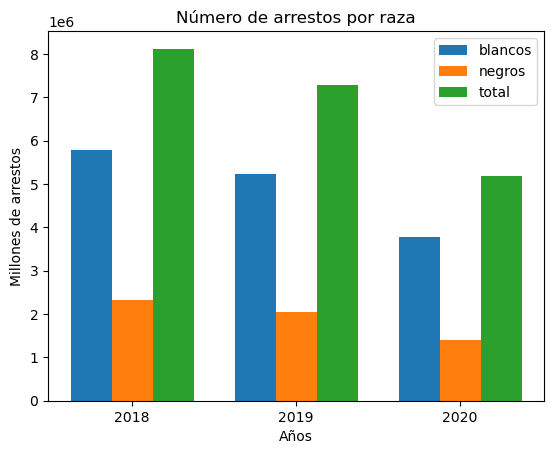

In [39]:
X = np.arange(3)

list(arrestos_w_usa.loc['usa'].values)

anos = ['2018', '2019', '2020']
X_axis = np.arange(len(anos))


plt.bar(X  - 0.25, arrestos_w_usa.loc['usa'].values ,width= 0.25, label='blancos')
plt.bar(X + 0,  arrestos_b_usa.loc['usa'].values, width= 0.25, label='negros')
plt.bar(X + 0.25,  arrestos_total_usa.loc['usa'].values, width= 0.25, label='total')

plt.xticks(X_axis, anos)

plt.xlabel('Años')
plt.ylabel('Millones de arrestos')
plt.title("Número de arrestos por raza")
plt.legend()
plt.show();


# ¿Existen grupos que tengan relacion basados en la informacion que tenemos?


In [40]:
scaler = StandardScaler()
data = df_final.drop(columns=['arrestos_w_2020', 'arrestos_b_2020', 'arrestos_total_2020',
       'arrestos_w_2019', 'arrestos_b_2019', 'arrestos_total_2019',
       'arrestos_w_2018', 'arrestos_b_2018', 'arrestos_total_2018',
       'state_name', 'poblacion_w_2020', 'poblacion_b_2020',
       'total_2020', 'poblacion_w_2019', 'poblacion_b_2019', 'total_2019',
       'poblacion_w_2018', 'poblacion_b_2018', 'total_2018'])
scaler_fit = scaler.fit_transform(data)


In [41]:
inertia = []
kmax = 10
for i in range(1,kmax):
    kmeans = KMeans(n_clusters = i, n_init = 10)
    kncl = kmeans.fit(scaler_fit)
    print(kncl.inertia_)
    
    inertia.append(kncl.inertia_)

588.0
278.2050762386303
186.61574714580428
113.98445457361986
92.6385379241054
77.38147768033285
58.42237201276444
47.91894346929112
37.75003297733036


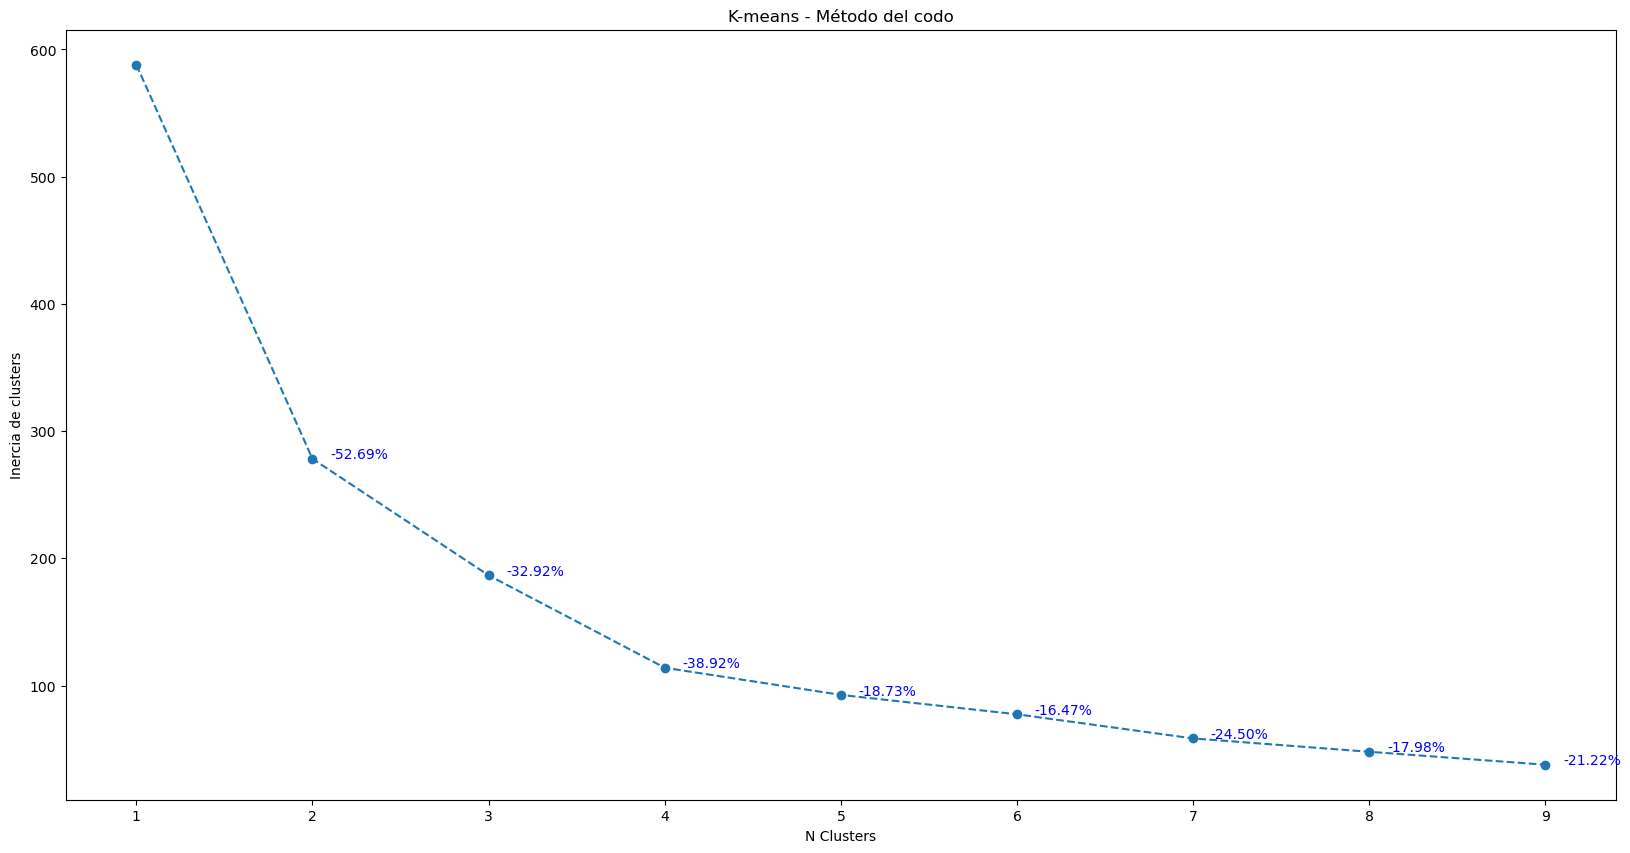

In [42]:
f, ax = plt.subplots(1,1, figsize=(20,10))

ax.plot(range(1,kmax),inertia,marker='o',ls='--')
ax.set_xlabel('N Clusters')
ax.set_ylabel('Inercia de clusters')
ax.set_title('K-means - Método del codo')

for i in range(1,len(inertia)):
    delta=(-inertia[i-1]+inertia[i])/inertia[i-1]*100
    ax.text(i+1.1,inertia[i],'%.2f'%delta+'%',color='b')
ax.set_xticks(range(1,kmax))

plt.show()

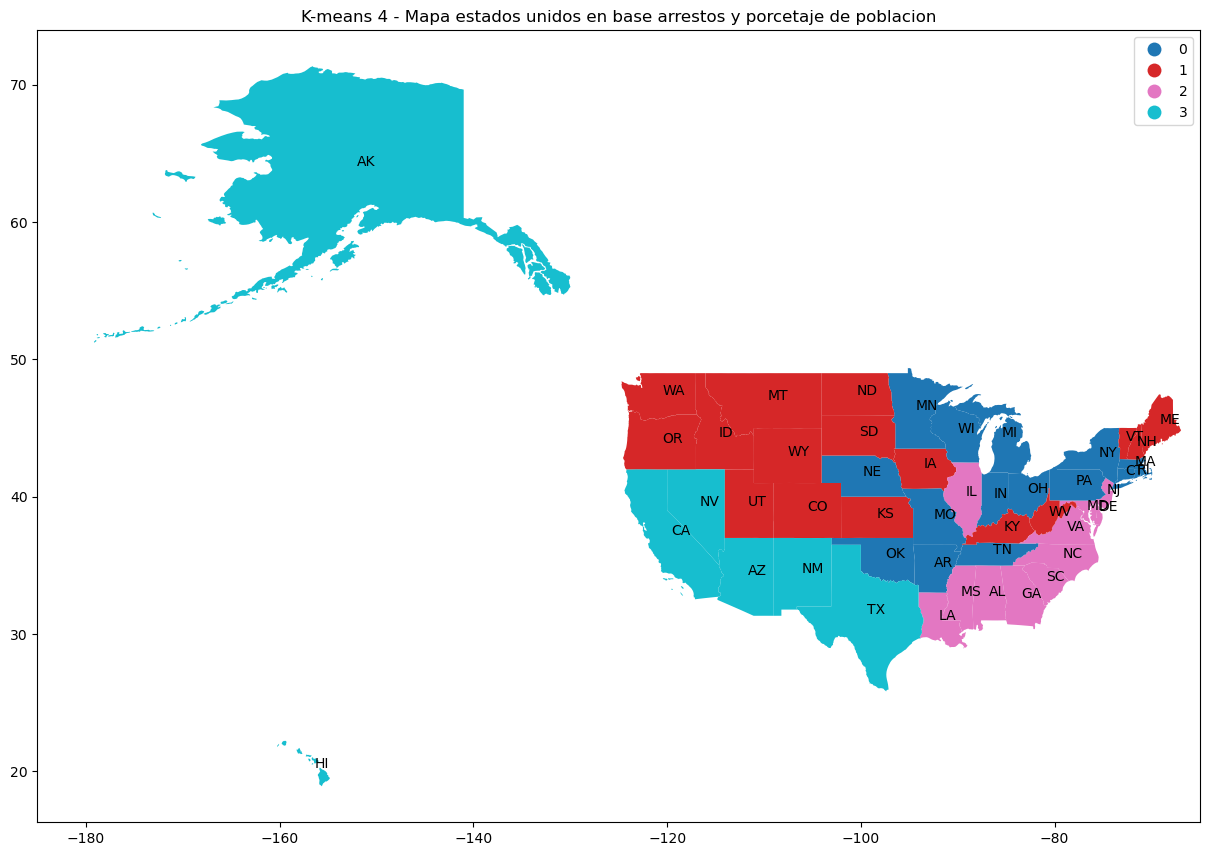

In [43]:
# 3
kmeans = KMeans(n_clusters = 4)
kncl = kmeans.fit(scaler_fit)

data['labels'] = kncl.labels_
df_mapa = pd.merge(data, states, left_on='state_abbr', right_on='STUSPS').set_index('STUSPS')

data_mapa = gpd.GeoDataFrame(df_mapa)

fig = plt.figure(figsize=(15,11))
ax = fig.add_subplot(111)
data_mapa.plot(column= 'labels', ax=ax, legend=True, categorical=True);
ax.set_title('K-means 4 - Mapa estados unidos en base arrestos y porcetaje de poblacion')

ax.set_xlim(-185, -65);

for i in data_mapa.index:
    plt.text(data_mapa.loc[i, 'geometry'].centroid.x , data_mapa.loc[i, 'geometry'].centroid.y , i)
    
plt.show()

In [44]:
kmeans = data.groupby('labels').mean()
kmeans.T

labels,0,1,2,3
porcentaje_arresto_w_2020,0.705101,0.892208,0.507093,0.817476
porcentaje_arresto_w_2019,0.712210,0.890659,0.505668,0.824117
porcentaje_arresto_w_2018,0.715570,0.894649,0.503703,0.831175
porcentaje_arresto_b_2020,0.294899,0.107792,0.492907,0.182524
porcentaje_arresto_b_2019,0.287790,0.109341,0.494332,0.175883
porcentaje_arresto_b_2018,0.284430,0.105351,0.496297,0.168825
porcentaje_w_2020,0.728143,0.822786,0.581125,0.426913
porcentaje_w_2019,0.732411,0.824673,0.588342,0.423782
porcentaje_w_2018,0.735514,0.826200,0.590881,0.426599
porcentaje_b_2020,0.101242,0.028068,0.247823,0.054634


In [45]:
import seaborn as sn
sn.heatmap(kmeans.T, vmin=0, vmax= 1, annot= True);